In [1]:
# plot the model domain and bathymetry

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.interpolate import RegularGridInterpolator

%matplotlib inline

# define grid spacings and domain

In [61]:
Ho = 4000  # depth of ocean (m)
nx = 932    # gridpoints in x
ny = 1142    # gridpoints in y
xo = 112.5     # origin in x,y for ocean domain
yo = -3.3    # (i.e. southwestern corner of ocean domain)
dx = 1/60     # grid spacing in x (degrees longitude)
dy = 1/60     # grid spacing in y (degrees latitude)
xeast  = xo + (nx-2)*dx   # eastern extent of ocean domain
ynorth = yo + (ny-2)*dy   # northern extent of ocean domain

# Flat bottom at z=-Ho
# h = -Ho * np.ones((ny, nx))

# create a border ring of walls around edge of domain
# h[:, [0,-1]] = 0   # set ocean depth to zero at east and west walls
# h[[0,-1], :] = 0   # set ocean depth to zero at south and north walls

In [62]:
x = np.linspace(xo-dx, xeast, nx) + dx/2
y = np.linspace(yo-dy, ynorth, ny) + dy/2

In [66]:
print(f'West BND: {x.max()}, East BND: {x.min()}')

West BND: 128.00833333333333, East BND: 112.49166666666667


In [67]:
print(f'North BND: {y.max()}, South BND: {y.min()}')

North BND: 15.708333333333332, South BND: -3.308333333333333


# 1. load GEBCO topography

In [40]:
ds_topo = xr.open_dataset('topo_sulu_from_gebco.nc')
ds_topo

<xarray.Dataset> Size: 69MB
Dimensions:    (lon: 4800, lat: 7200)
Coordinates:
  * lon        (lon) float64 38kB 110.0 110.0 110.0 110.0 ... 130.0 130.0 130.0
  * lat        (lat) float64 58kB -9.998 -9.994 -9.99 ... 19.99 19.99 20.0
Data variables:
    elevation  (lat, lon) int16 69MB ...

In [41]:
# Prepare the interpolator for the toposulu data
interp_func = RegularGridInterpolator(
    (ds_topo.lat.values, ds_topo.lon.values),
    ds_topo.elevation.values,
    bounds_error=False,
    fill_value=np.nan
)

# Create meshgrid for x and y
X, Y = np.meshgrid(x, y)
points = np.column_stack([Y.ravel(), X.ravel()])

# Interpolate toposulu onto the (x, y) grid
sulutopo_interp = interp_func(points).reshape(Y.shape)

sulutopo_interp[np.where(sulutopo_interp>=0)]=np.nan
sulutopo_interp[np.where(sulutopo_interp<=-6000)]=-6000

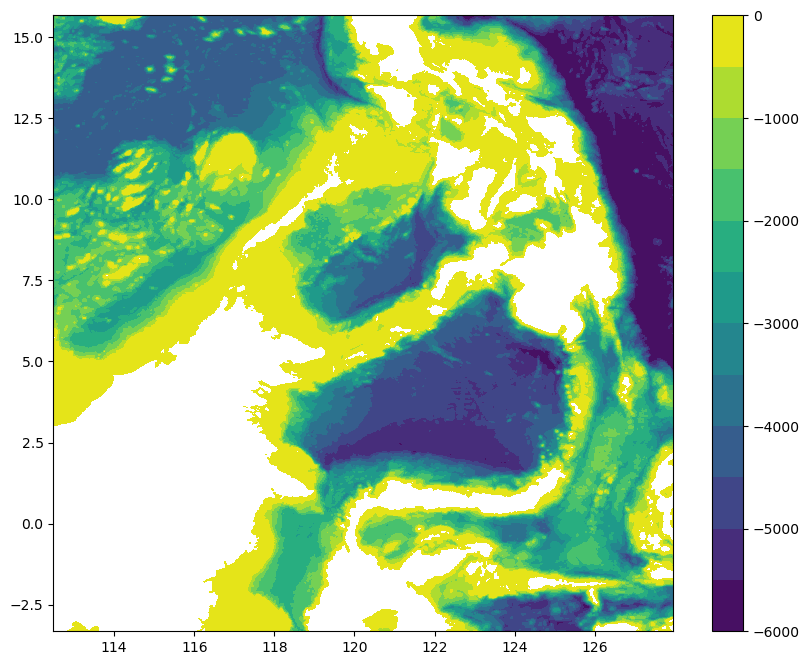

In [42]:
plt.figure(figsize=(10,8))
plt.contourf(x,y,sulutopo_interp,levels=np.arange(-6000,500,500))
plt.colorbar()
# plt.show()